In [14]:
from __future__ import print_function, division
import mdtraj as md
from mdtraj.utils import ensure_type
from mdtraj.geometry import compute_distances, compute_angles
from mdtraj.geometry import _geometry
import os
import sys
import numpy as np
import scipy as sp
from scipy import optimize
from scipy.optimize import leastsq
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import math
import itertools    
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
import pyblock
from mdtraj.geometry import _geometry
from mdtraj.utils import ensure_type
from mdtraj.geometry import compute_distances, compute_angles
from scipy.stats import pearsonr
import json

class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

In [2]:
# block function from pyblock package -  https://github.com/jsspencer/pyblock
def block(x):
    # preliminaries
    d = log2(len(x))
    if (d - floor(d) != 0):
        x = x[:2**int(floor(d))]
    d = int(floor(d))
    n = 2**d
    s, gamma = zeros(d), zeros(d)
    mu = mean(x)
    # estimate the auto-covariance and variances
    # for each blocking transformation
    for i in arange(0, d):
        n = len(x)
        # estimate autocovariance of x
        gamma[i] = (n)**(-1)*sum((x[0:(n-1)]-mu)*(x[1:n]-mu))
        # estimate variance of x
        s[i] = var(x)
        # perform blocking transformation
        x = 0.5*(x[0::2] + x[1::2])

    # generate the test observator M_k from the theorem
    M = (cumsum(((gamma/s)**2*2**arange(1, d+1)[::-1])[::-1]))[::-1]

    # we need a list of magic numbers
    q = array([6.634897,  9.210340,  11.344867, 13.276704, 15.086272,
              16.811894, 18.475307, 20.090235, 21.665994, 23.209251,
              24.724970, 26.216967, 27.688250, 29.141238, 30.577914,
              31.999927, 33.408664, 34.805306, 36.190869, 37.566235,
              38.932173, 40.289360, 41.638398, 42.979820, 44.314105,
              45.641683, 46.962942, 48.278236, 49.587884, 50.892181])

    # use magic to determine when we should have stopped blocking
    for k in arange(0, d):
        if(M[k] < q[k]):
            break
    if (k >= d-1):
        print("Warning: Use more data")

    return (s[k]/2**(d-k))


def free_energy_1D_blockerror(a, T, x0, xmax, bins, blocks):
    histo, xedges = np.histogram(
        a, bins=bins, range=[x0, xmax], density=True, weights=None)
    max = np.max(histo)
    # free_energy=-(0.001987*T)*np.log(histo)
    free_energy = -(0.001987*T)*np.log(histo+.000001)
    free_energy = free_energy-np.min(free_energy)
    xcenters = xedges[:-1] + np.diff(xedges)/2
    Ind = chunkIt(len(a), blocks)
    block_size = (Ind[0][1]-Ind[0][0])
    hist_blocks = []
    for i in range(0, len(Ind)):
        block_data = a[Ind[i][0]:Ind[i][1]]
        hist, binedges = np.histogram(block_data, bins=bins, range=[
                                      x0, xmax], density=True, weights=None)
        hist_blocks.append(hist)
    hist_blocks = np.array(hist_blocks)
    average = np.average(hist_blocks, axis=0)
    variance = np.var(hist_blocks, axis=0)
    N = len(hist_blocks)
    error = np.sqrt(variance / N)
    ferr = -(0.001987*T)*(error / average)
    return free_energy, xcenters, ferr


def chunkIt(a, num):
    avg = a / float(num)
    out = []
    last = 0.0
    while last < a-1:
        out.append([int(last), int(last+avg)])
        last += avg
    return out


def histo_blockerror(a, x0, xmax, bins, blocks):
    histo, xedges = np.histogram(
        a, bins=bins, range=[x0, xmax], density=True, weights=None)
    xcenters = xedges[:-1] + np.diff(xedges)/2
    Ind = chunkIt(len(a), blocks)
    block_size = (Ind[0][1]-Ind[0][0])
    hist_blocks = []
    for i in range(0, len(Ind)):
        block_data = a[Ind[i][0]:Ind[i][1]]
        hist, binedges = np.histogram(block_data, bins=bins, range=[
                                      x0, xmax], density=True, weights=None)
        hist_blocks.append(hist)
    hist_blocks = np.array(hist_blocks)
    average = np.average(hist_blocks, axis=0)
    variance = np.var(hist_blocks, axis=0)
    N = len(hist_blocks)
    error = np.sqrt(variance / N)
    return average, xcenters, error


def Kd_calc(bound, conc):
    return((1-bound)*conc/bound)


def get_blockerrors(Data, bound_frac):
    n_data = len(Data[0])
    block_errors = []
    ave = []
    for i in range(0, n_data):
        data = Data[:, i]
        average = np.average(data)
        be = block(data)**.5
        ave.append(np.average(data))
        block_errors.append(be)
    ave_bf = np.asarray(ave)/bound_frac
    be_bf = np.asarray(block_errors)/bound_frac

    return ave_bf, be_bf


def get_blockerrors_pyblock(Data, bound_frac):
    n_data = len(Data[0])
    block_errors = []
    ave = []
    for i in range(0, n_data):
        data = Data[:, i]
        average = np.average(data)
        if (average != 0) and (average != 1):
            reblock_data = pyblock.blocking.reblock(data)
            opt = pyblock.blocking.find_optimal_block(
                len(data), reblock_data)[0]
            opt_block = reblock_data[opt]
            be = opt_block[4]
        else:
            be = 0
        ave.append(average)
        block_errors.append(be)

    ave_bf = np.asarray(ave)/bound_frac
    be_bf = np.asarray(block_errors)/bound_frac
    return ave_bf, be_bf


def get_blockerror(Data):
    data = Data
    average = np.average(data)
    be = block(data)**.5
    return average, be


def get_blockerror_pyblock(Data):
    average = np.average(Data)
    if (average != 0) and (average != 1):
        reblock_data = pyblock.blocking.reblock(Data)
        opt = pyblock.blocking.find_optimal_block(len(Data), reblock_data)[0]
        be = reblock_data[opt][4]
    else:
        be = 0
    return average, float(be)


def get_blockerror_pyblock_nanskip(Data):
    average = np.average(Data)
    if (average != 0) and (average != 1):
        reblock_data = pyblock.blocking.reblock(Data)
        opt = pyblock.blocking.find_optimal_block(len(Data), reblock_data)[0]
        if(math.isnan(opt)):
            be_max = 0
            for i in range(0, len(reblock_data)):
                be = reblock_data[i][4]
                if(be > be_max):
                    be_max = be
        else:
            be = reblock_data[opt][4]
    else:
        be = 0
    return average, float(be)

def get_blockerrors_pyblock_nanskip(Data, bound_frac):
    n_data = len(Data[0])
    block_errors = []
    ave = []
    for i in range(0, n_data):
        data = Data[:, i]
        average = np.average(data)
        if (average != 0) and (average != 1):
            reblock_data = pyblock.blocking.reblock(data)
            opt = pyblock.blocking.find_optimal_block(len(data), reblock_data)[0]
 #           opt_block = reblock_data[opt]
 #           be = opt_block[4]
            if (math.isnan(opt)):
                be_max=0
                for i in range(0, len(reblock_data)):
                    be = reblock_data[i][4]
                    if (be > be_max) :
                        be_max=be
            else:
                be = reblock_data[opt][4]
            
        else:
            be = 0
        ave.append(average)
        block_errors.append(be)

    ave_bf = np.asarray(ave)/bound_frac
    be_bf = np.asarray(block_errors)/bound_frac
    return ave_bf, be_bf

def get_blockerror_pyblock_max(Data):
    average=np.average(Data)
    if (average!=0) and (average!=1):
        reblock_data = pyblock.blocking.reblock(Data)
        be_max=0
        for i in range(0,len(reblock_data)): 
            be=reblock_data[i][4]
            if(be > be_max):
                be_max=be
    else:
        be=0
    return average,float(be)

def calc_SA(trj, helix, start, stop):
    r0 = .10
    RMS_start = start
    RMS_stop = stop
    RMS = []
    for i in range(RMS_start, RMS_stop):
        sel = helix.topology.select("residue %s to %s and name CA" % (i, i+6))
        rmsd = md.rmsd(trj, helix, atom_indices=sel)
        RMS.append(rmsd)
    RMS = np.asarray(RMS)
    Sa_sum = np.zeros((trj.n_frames))
    Sa = (1.0-(RMS/0.10)**8)/(1-(RMS/0.10)**12)
    return Sa


def calc_Rg(trj):
    mass = []
    for at in trj.topology.atoms:
        mass.append(at.element.mass)
    mass_CA = len(mass)*[0.0]
    for i in trj.topology.select("name CA"):
        mass_CA[i] = 1.0
    rg_CA = md.compute_rg(trj, masses=np.array(mass_CA))
    return rg_CA


def free_energy(a, b, T, y0, ymax, x0, xmax):
    free_energy, xedges, yedges = np.histogram2d(
        a, b, 30, [[y0, ymax], [x0, xmax]], normed=True, weights=None)
    free_energy = np.log(np.flipud(free_energy)+.000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xedges, yedges


def free_energy_reweight(a, b, T, y0, ymax, x0, xmax, weight):
    free_energy, xedges, yedges = np.histogram2d(
        a, b, 30, [[y0, ymax], [x0, xmax]], normed=True, weights=weight)
    free_energy = np.log(np.flipud(free_energy)+.000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xedges, yedges


def free_energy_1D_noscale(a, T, x0, xmax, bins):
    free_energy, xedges = np.histogram(
        a, bins=bins, range=[x0, xmax], density=True, weights=None)
    free_energy = np.log(free_energy+.000001)
    free_energy = -(0.001987*T)*free_energy
    xcenters = xedges[:-1] + np.diff(xedges)/2
    return free_energy, xcenters


def free_energy_1D(a, T, x0, xmax, bins):
    free_energy, xedges = np.histogram(
        a, bins=bins, range=[x0, xmax], density=True, weights=None)
    max = np.max(free_energy)
    free_energy = np.log(free_energy+.0000001)
    free_energy = -(0.001987*T)*(free_energy-np.log(max+.0000001))
    xcenters = xedges[:-1] + np.diff(xedges)/2
    return free_energy, xcenters


def free_energy_1D_reweight(a, T, x0, xmax, bins, weight):
    free_energy, xedges = np.histogram(
        a, bins=bins, range=[x0, xmax], density=True, weights=weight)
    max = np.max(free_energy)
    free_energy = np.log(free_energy+.0000001)
    free_energy = -(0.001987*T)*(free_energy-np.log(max+.0000001))
    xcenters = xedges[:-1] + np.diff(xedges)/2
    return free_energy, xcenters


def alphabeta_rmsd(phi, psi, phi_ref, psi_ref):
    alphabetarmsd = np.sum(0.5*(1+np.cos(psi-psi_ref)),
                           axis=1)+np.sum(0.5*(1+np.cos(phi-phi_ref)), axis=1)
    return alphabetarmsd


def dssp_convert(dssp):
    dsspH = np.copy(dssp)
    dsspE = np.copy(dssp)
    dsspH[dsspH == 'H'] = 1
    dsspH[dsspH == 'E'] = 0
    dsspH[dsspH == 'C'] = 0
    dsspH[dsspH == 'NA'] = 0
    dsspH = dsspH.astype(int)
    TotalH = np.sum(dsspH, axis=1)
    SE_H = np.zeros((len(dssp[0]), 2))

    for i in range(0, len(dssp[0])):
        data = dsspH[:, i].astype(float)
        if(np.mean(data) > 0):
            SE_H[i] = [np.mean(data), (block(data))**.5]

    dsspE[dsspE == 'H'] = 0
    dsspE[dsspE == 'E'] = 1
    dsspE[dsspE == 'C'] = 0
    dsspE[dsspE == 'NA'] = 0
    dsspE = dsspE.astype(int)
    TotalE = np.sum(dsspE, axis=1)
    Eprop = np.sum(dsspE, axis=0).astype(float)/len(dsspE)
    SE_E = np.zeros((len(dssp[0]), 2))

    for i in range(0, len(dssp[0])):
        data = dsspE[:, i].astype(float)
        if(np.mean(data) > 0):
            SE_E[i] = [np.mean(data), (block(data))**.5]
    return SE_H, SE_E


def calc_phipsi(trj):
    indices_phi, phis = md.compute_phi(trj)
    indices_psi, psis = md.compute_psi(trj)
    phi_label = []
    for i_phi in range(0, indices_phi.shape[0]):
        resindex = trj.topology.atom(indices_phi[i_phi][2]).residue.resSeq
        phi_label.append(resindex)
    phi_label = np.array(phi_label)
    psi_label = []
    for i_psi in range(0, indices_psi.shape[0]):
        resindex = trj.topology.atom(indices_psi[i_psi][2]).residue.resSeq
        psi_label.append(resindex)
    psi_label = np.array(psi_label)
    phipsi = []
    for i in range(0, len(phi_label)-1):
        current_phipsi = np.column_stack((phis[:, i+1], psis[:, i]))
        phipsi.append(current_phipsi)
    phipsi_array = np.array(phipsi)
    return(phipsi_array, psi_label, phi_label)

# Functions to Calculate Aromatic Stacking Interactions

def find_plane_normal(points):

    N = points.shape[0]
    A = np.concatenate((points[:, 0:2], np.ones((N, 1))), axis=1)
    B = points[:, 2]
    out = lstsq(A, B, rcond=-1)
    na_c, nb_c, d_c = out[0]
    if d_c != 0.0:
        cu = 1./d_c
        bu = -nb_c*cu
        au = -na_c*cu
    else:
        cu = 1.0
        bu = -nb_c
        au = -na_c
    normal = np.asarray([au, bu, cu])
    normal /= math.sqrt(dot(normal, normal))
    return normal


def find_plane_normal2(positions):
    # Alternate approach used to check sign - could the sign check cause descrepency with desres?
    # Use Ligand IDs 312, 308 and 309 to check direction
    # [304 305 306 307 308 309 310 311 312 313]
    v1 = positions[0]-positions[1]
    v1 /= np.sqrt(np.sum(v1**2))
    v2 = positions[2]-positions[1]
    v2 /= np.sqrt(np.sum(v2**2))
    normal = np.cross(v1, v2)
    return normal


def find_plane_normal2_assign_atomid(positions, id1, id2, id3):
    # Alternate approach used to check sign - could the sign check cause descrepency with desres?
    v1 = positions[id1]-positions[id2]
    v1 /= np.sqrt(np.sum(v1**2))
    v2 = positions[id3]-positions[id1]
    v2 /= np.sqrt(np.sum(v2**2))
    normal = np.cross(v1, v2)
    return normal


def get_ring_center_normal_assign_atomid(positions, id1, id2, id3):
    center = np.mean(positions, axis=0)
    normal = find_plane_normal(positions)
    normal2 = find_plane_normal2_assign_atomid(positions, id1, id2, id3)
    # check direction of normal using dot product convention
    comp = np.dot(normal, normal2)
    if comp < 0:
        normal = -normal
    return center, normal


def get_ring_center_normal_(positions):
    center = np.mean(positions, axis=0)
    normal = find_plane_normal(positions)
    normal2 = find_plane_normal2(positions)
    # check direction of normal using dot product convention
    comp = np.dot(normal, normal2)
    if comp < 0:
        normal = -normal
    return center, normal


def angle(v1, v2):
    return np.arccos(np.dot(v1, v2)/(np.sqrt(np.dot(v1, v1))*np.sqrt(np.dot(v2, v2))))


def get_ring_center_normal_trj_assign_atomid(position_array, id1, id2, id3):
    length = len(position_array)
    centers = np.zeros((length, 3))
    normals = np.zeros((length, 3))
    centers_normals = np.zeros((length, 2, 3))
    print(np.shape(length), np.shape(centers), np.shape(normals))
    for i in range(0, len(position_array)):
        center, normal = get_ring_center_normal_assign_atomid(
            position_array[i], id1, id2, id3)
        centers_normals[i][0] = center
        centers_normals[i][1] = normal
    return centers_normals

# MDtraj Functions to Calculate Hydrogen Bonds with custom selections of donors and acceptors

def _get_bond_triplets_print(topology, lig_donors, exclude_water=True, sidechain_only=False):
    def can_participate(atom):
        # Filter waters
        if exclude_water and atom.residue.is_water:
            return False
        # Filter non-sidechain atoms
        if sidechain_only and not atom.is_sidechain:
            return False
        # Otherwise, accept it
        return True

    def get_donors(e0, e1):
        # Find all matching bonds
        # print("get_donors e0 e1:",e0,e1)
        elems = set((e0, e1))
        atoms = [(one, two) for one, two in topology.bonds
                 if set((one.element.symbol, two.element.symbol)) == elems]
        # Filter non-participating atoms
        atoms = [atom for atom in atoms
                 if can_participate(atom[0]) and can_participate(atom[1])]
        # Get indices for the remaining atoms
        indices = []
        for a0, a1 in atoms:
            pair = (a0.index, a1.index)
            # make sure to get the pair in the right order, so that the index
            # for e0 comes before e1
            if a0.element.symbol == e1:
                pair = pair[::-1]
            indices.append(pair)

        return indices

    # Check that there are bonds in topology
    nbonds = 0
    for _bond in topology.bonds:
        nbonds += 1
        break  # Only need to find one hit for this check (not robust)
    if nbonds == 0:
        raise ValueError('No bonds found in topology. Try using '
                         'traj._topology.create_standard_bonds() to create bonds '
                         'using our PDB standard bond definitions.')

    nh_donors = get_donors('N', 'H')
    print("nh_donors", nh_donors)
    for i in nh_donors:
        print(top.atom(i[0]), top.atom(i[1]))
    oh_donors = get_donors('O', 'H')
    print("oh_donors", oh_donors)
    for i in oh_donors:
        print(top.atom(i[0]), top.atom(i[1]))
    sh_donors = get_donors('S', 'H')
    print("sh_donors", sh_donors)
    for i in sh_donors:
        print(top.atom(i[0]), top.atom(i[1]))
    for i in lig_donors:
        print(top.atom(i[0]), top.atom(i[1]))
    # ADD IN ADDITIONAL SPECIFIED LIGAND DONORS
    xh_donors = np.array(nh_donors + oh_donors + sh_donors+lig_donors)

    if len(xh_donors) == 0:
        # if there are no hydrogens or protein in the trajectory, we get
        # no possible pairs and return nothing
        return np.zeros((0, 3), dtype=int)

    acceptor_elements = frozenset(('O', 'N', 'S'))
    acceptors = [a.index for a in topology.atoms
                 if a.element.symbol in acceptor_elements and can_participate(a)]
    print("acceptors")
    for i in acceptors:
        print(top.atom(i))
    # Make acceptors a 2-D numpy array
    acceptors = np.array(acceptors)[:, np.newaxis]

    # Generate the cartesian product of the donors and acceptors
    xh_donors_repeated = np.repeat(xh_donors, acceptors.shape[0], axis=0)
    acceptors_tiled = np.tile(acceptors, (xh_donors.shape[0], 1))
    bond_triplets = np.hstack((xh_donors_repeated, acceptors_tiled))

    # Filter out self-bonds
    self_bond_mask = (bond_triplets[:, 0] == bond_triplets[:, 2])
    return bond_triplets[np.logical_not(self_bond_mask), :]


def _get_bond_triplets(topology, lig_donors, exclude_water=True, sidechain_only=False):
    def can_participate(atom):
        # Filter waters
        if exclude_water and atom.residue.is_water:
            return False
        # Filter non-sidechain atoms
        if sidechain_only and not atom.is_sidechain:
            return False
        # Otherwise, accept it
        return True

    def get_donors(e0, e1):
        # Find all matching bonds
        elems = set((e0, e1))
        atoms = [(one, two) for one, two in topology.bonds
                 if set((one.element.symbol, two.element.symbol)) == elems]
        # Filter non-participating atoms
        atoms = [atom for atom in atoms
                 if can_participate(atom[0]) and can_participate(atom[1])]
        # Get indices for the remaining atoms
        indices = []
        for a0, a1 in atoms:
            pair = (a0.index, a1.index)
            # make sure to get the pair in the right order, so that the index
            # for e0 comes before e1
            if a0.element.symbol == e1:
                pair = pair[::-1]
            indices.append(pair)

        return indices

    # Check that there are bonds in topology
    nbonds = 0
    for _bond in topology.bonds:
        nbonds += 1
        break  # Only need to find one hit for this check (not robust)
    if nbonds == 0:
        raise ValueError('No bonds found in topology. Try using '
                         'traj._topology.create_standard_bonds() to create bonds '
                         'using our PDB standard bond definitions.')

    nh_donors = get_donors('N', 'H')
    oh_donors = get_donors('O', 'H')
    sh_donors = get_donors('S', 'H')
    xh_donors = np.array(nh_donors + oh_donors + sh_donors+lig_donors)

    if len(xh_donors) == 0:
        # if there are no hydrogens or protein in the trajectory, we get
        # no possible pairs and return nothing
        return np.zeros((0, 3), dtype=int)

    acceptor_elements = frozenset(('O', 'N', 'S'))
    acceptors = [a.index for a in topology.atoms
                 if a.element.symbol in acceptor_elements and can_participate(a)]
    # Make acceptors a 2-D numpy array
    acceptors = np.array(acceptors)[:, np.newaxis]

    # Generate the cartesian product of the donors and acceptors
    xh_donors_repeated = np.repeat(xh_donors, acceptors.shape[0], axis=0)
    acceptors_tiled = np.tile(acceptors, (xh_donors.shape[0], 1))
    bond_triplets = np.hstack((xh_donors_repeated, acceptors_tiled))

    # Filter out self-bonds
    self_bond_mask = (bond_triplets[:, 0] == bond_triplets[:, 2])
    return bond_triplets[np.logical_not(self_bond_mask), :]


def _compute_bounded_geometry(traj, triplets, distance_cutoff, distance_indices,
                              angle_indices, freq=0.0, periodic=True):
    """
    Returns a tuple include (1) the mask for triplets that fulfill the distance
    criteria frequently enough, (2) the actual distances calculated, and (3) the
    angles between the triplets specified by angle_indices.
    """
    # First we calculate the requested distances
    distances = md.compute_distances(
        traj, triplets[:, distance_indices], periodic=periodic)

    # Now we discover which triplets meet the distance cutoff often enough
    prevalence = np.mean(distances < distance_cutoff, axis=0)
    mask = prevalence > freq

    # Update data structures to ignore anything that isn't possible anymore
    triplets = triplets.compress(mask, axis=0)
    distances = distances.compress(mask, axis=1)

    # Calculate angles using the law of cosines
    abc_pairs = zip(angle_indices, angle_indices[1:] + angle_indices[:1])
    abc_distances = []

    # Calculate distances (if necessary)
    for abc_pair in abc_pairs:
        if set(abc_pair) == set(distance_indices):
            abc_distances.append(distances)
        else:
            abc_distances.append(md.compute_distances(traj, triplets[:, abc_pair],
                                                      periodic=periodic))

    # Law of cosines calculation
    a, b, c = abc_distances
    cosines = (a ** 2 + b ** 2 - c ** 2) / (2 * a * b)
    np.clip(cosines, -1, 1, out=cosines)  # avoid NaN error
    angles = np.arccos(cosines)
    return mask, distances, angles


def baker_hubbard2(traj, freq=0.1, exclude_water=True, periodic=True, sidechain_only=False,
                   distance_cutoff=0.35, angle_cutoff=150, lig_donor_index=[]):

    angle_cutoff = np.radians(angle_cutoff)

    if traj.topology is None:
        raise ValueError('baker_hubbard requires that traj contain topology '
                         'information')

    # Get the possible donor-hydrogen...acceptor triplets

    # ADD IN LIGAND HBOND DONORS
    add_donors = lig_donor_index

    bond_triplets = _get_bond_triplets(traj.topology,
                                       exclude_water=exclude_water, lig_donors=add_donors, sidechain_only=sidechain_only)

    mask, distances, angles = _compute_bounded_geometry(traj, bond_triplets,
                                                        distance_cutoff, [1, 2], [0, 1, 2], freq=freq, periodic=periodic)

    # Find triplets that meet the criteria
    presence = np.logical_and(
        distances < distance_cutoff, angles > angle_cutoff)
    mask[mask] = np.mean(presence, axis=0) > freq
    return bond_triplets.compress(mask, axis=0)


def print_donors_acceptors(traj, freq=0.1, exclude_water=True, periodic=True, sidechain_only=False,
                           distance_cutoff=0.35, angle_cutoff=150, lig_donor_index=[]):

    angle_cutoff = np.radians(angle_cutoff)

    if traj.topology is None:
        raise ValueError('baker_hubbard requires that traj contain topology '
                         'information')

    # Get the possible donor-hydrogen...acceptor triplets

    # ADD IN LIGAND HBOND DONORS
    # add_donors=[[296,318],[296,331]]
    # Manually tell it where to find proton donors on ligand
    # LIG58-O5 LIG58-H24
    # LIG58-O1 LIG58-H12
    # LIG58-N LIG58-H15
    # add_donors=[[768,796],[750,784],[752,787]]
    add_donors = lig_donor_index

    bond_triplets_print = _get_bond_triplets_print(traj.topology,
                                                   exclude_water=exclude_water, lig_donors=add_donors, sidechain_only=sidechain_only)

    # mask, distances, angles = _compute_bounded_geometry(traj, bond_triplets,
    #    distance_cutoff, [1, 2], [0, 1, 2], freq=freq, periodic=periodic)

    # Find triplets that meet the criteria
    # presence = np.logical_and(distances < distance_cutoff, angles > angle_cutoff)
    # mask[mask] = np.mean(presence, axis=0) > freq
    return

def bound_frac_kd(box_len,n_reps,contact_matrix=[],trj_frames=[]):
    
    Box_L = box_len
    # Convert nM to meters for Box_V in M^3
    Box_V = (Box_L*10**-9)**3
    # Convert Box_V to L
    Box_V_L = Box_V*1000
    #Concentraion in Mols/L
    Concentration = 1/(Box_V_L*(6.023*10**23))
    #print("L:", Box_L, "V:", Box_V, "Conc:", Concentration)
    OUT=[]
    for i in range(n_reps):

        contact_rows = np.sum(contact_matrix[int(trj_frames[str(i)][0]):int(trj_frames[str(i)][1])], axis=1)
        bf, bf_be = get_blockerror_pyblock(np.where(contact_rows > 0, 1, 0))
    
        upper = bf+bf_be
        KD = Kd_calc(bf, Concentration)
        KD_upper = Kd_calc(upper, Concentration)
        KD_error = KD-KD_upper
    
        kd=np.round(KD*1000,4)
        kde=np.round(KD_error*1000,4)
    
        OUT.append([bf, bf_be, kd, kde])
    
    OUT=np.array(OUT)
    
    return OUT

def vec_angles(trj,atom_indices=[]):
    
    #Get xyz co-ordinates
    xyz=[]
    for  atom_idx in atom_indices :
        a=[]
        for frame_idx in range(trj.n_frames):

            a.append(trj.xyz[frame_idx, atom_idx,:].astype(float))
        xyz.append(a)    

    xyz=np.array(xyz)
    xyz.shape

    #Define vectors with 2nd atom as starting point
    V=[]
    v1=xyz[0]-xyz[1]
    v2=xyz[2]-xyz[1]
    V.append(v1)
    V.append(v2)

    #Compute angles between two vectors
    angles=[]
    for i in range(trj.n_frames):
    
        a=np.rad2deg(np.arccos(np.dot(V[0][i],V[1][i])/
                               (np.sqrt(np.dot(V[0][i],V[0][i])*np.dot(V[1][i],V[1][i])))))
        
        angles.append(a)
    
    angles=np.array(angles)
    
    return angles

def norm_weights(file_name):

    colvar=np.loadtxt(file_name,comments=['#','@'])
    num_cvs=len(colvar[0])-1



    kt=2.494339
    w=np.exp((colvar[:,num_cvs]/kt))


    max_=np.sum(w)
    w_norm=w/max_

    return num_cvs, w, w_norm

In [3]:
ligand_rings=[[307,308,309,311,313,314]]

lig_hbond_donors=[[329,331],[329,330]]

Ligand_Pos_Charges=[329]
Ligand_Neg_Charges=[]

In [4]:
out_dir='/home/jaya/work/master_books/data/anton/lig47/'

In [6]:
xtc='/data/Jaya_Krishna/analysis_trajectories/async/anton/async_lig47.dcd'
pdb='/data/Jaya_Krishna/analysis_trajectories/async/anton/asyn_cterm_lig47.pdb'

trj=md.load(xtc, top=pdb, stride=1)
trj.center_coordinates()
top = trj.topology


In [7]:
residues = 21
residue_offset = 121
residue_number = range(0, residues)
residue_number_offset = range(residue_offset, residue_offset+residues)

Fraction Bound: 0.8328707908710952


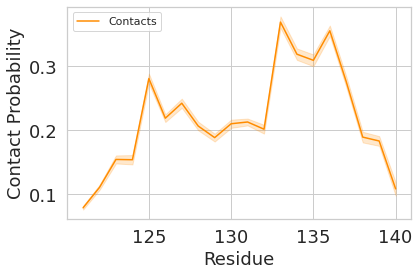

In [11]:
# Calculate Contact Probabilities between each protein residue and the ligand
#residue_number = range(residue_offset, residue_offset+residues)
contact_pairs = np.zeros((residues-1, 2))
ligand_residue_index = 21

for i in range(0, residues-1):
    contact_pairs[i] = [i, ligand_residue_index]
contact = md.compute_contacts(trj, contact_pairs, scheme='closest-heavy')


contacts = np.asarray(contact[0]).astype(float)
cutoff = 0.6
contact_matrix = np.where(contacts < cutoff, 1, 0)
contact_prob = np.sum(contact_matrix, axis=0)/trj.n_frames
#np.savetxt(outdir+'contacts.traj.dat', contact_matrix, '%i')


contact_rows = np.sum(contact_matrix, axis=1)
contact_frames = np.where(contact_rows > 0)[0]
nocontact_frames = np.where(contact_rows == 0)[0]
contact_fraction = np.sum(np.where(contact_rows > 0, 1, 0))/len(contact_rows)
print("Fraction Bound:", contact_fraction)

contact_ave, contact_pyb_be = get_blockerrors_pyblock(contact_matrix, 1.0)
contact_ave, contact_pyb_be_max = get_blockerrors_pyblock(contact_matrix, 1.0)

resnum = range(121,141)
contact_be = np.column_stack((resnum, contact_ave, contact_pyb_be))
contact_be_max = np.column_stack((resnum, contact_ave, contact_pyb_be_max))

# np.savetxt('%s/contact.be.pyblock.dat' % outdir, contact_be, '%.4f')
# np.savetxt('%s/contact.be.pyblock.max.dat' % outdir, contact_be_max, '%.4f')
sns.set(style='whitegrid')

Contact = contact_be
sns.lineplot(x=Contact[:, 0], y=Contact[:, 1],
             color='darkorange', label='Contacts')
#plt.plot(Contact[:, 0], Contact[:, 1],color='darkorange', label='Contacts')


plt.fill_between(Contact[:, 0], Contact[:, 1]+Contact[:, 2],
                 Contact[:, 1]-Contact[:, 2], color='darkorange', alpha=0.2)

plt.xlabel('Residue', size=18)
plt.ylabel('Contact Probability', size=18)
#plt.ylim(0, 0.5)
plt.tick_params(labelsize=18)
#plt.xlim(residue_offset, residue_offset+residues-1)
plt.tight_layout()
#plt.savefig(outdir+'ContactFraction.byResidue.ClosestHeavy.png')
plt.show()

In [33]:
np.savetxt(out_dir+'contact_prob.dat',contact_be)

In [12]:
Box_L = trj.unitcell_lengths[0][0]
# Convert nM to meters for Box_V in M^3
Box_V = (Box_L*10**-9)**3
# Convert Box_V to L
Box_V_L = Box_V*1000
#Concentraion in Mols/L
Concentration = 1/(Box_V_L*(6.023*10**23))
print("L:", Box_L, "V:", Box_V, "Conc:", Concentration)

contact_binary = np.where(contact_rows > 0, 1, 0)
boundfrac, boundfrac_be = get_blockerror_pyblock(contact_binary)
print("Bound Fraction:", boundfrac, "+_", boundfrac_be)
upper = boundfrac+boundfrac_be
KD = Kd_calc(boundfrac, Concentration)
KD_upper = Kd_calc(upper, Concentration)
KD_error = KD-KD_upper
print("KD (mM):", KD*1000, "+_", KD_error*1000)

L: 4.254648 V: 7.701777537942805e-26 Conc: 0.021557389405450513
Bound Fraction: 0.8328707908710952 +_ 0.003410126848606853
KD (mM): 4.325844394721243 +_ 0.10554480993229826


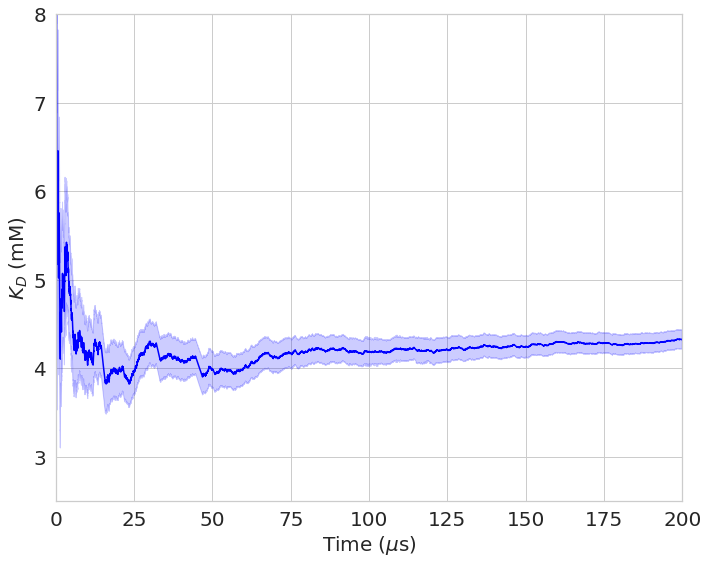

In [11]:
# Time Series of KD Calculations
sim_length=200 #in micro-secs

time = np.linspace(0, sim_length, len(contact_binary))
boundfrac_by_frame = []
t2 = []
err_by_frame = []
err_upper = []
err_lower = []
stride = 10

for i in range(stride, len(contact_binary), stride):
    Data = np.asarray(contact_binary[0:i])
    bf, be = get_blockerror_pyblock_nanskip(Data)
    boundfrac_by_frame.append(bf)
    err_by_frame.append(be)
    err_upper.append(bf-be)
    err_lower.append(bf+be)
    t2.append(time[i])

Kd = Kd_calc(np.asarray(boundfrac_by_frame), Concentration)*1000
Kd_upper = Kd_calc(np.asarray(err_upper), Concentration)*1000
Kd_lower = Kd_calc(np.asarray(err_lower), Concentration)*1000
np.savetxt('%s/KD.timecourse.errors.dat' %
           (out_dir), np.column_stack((t2, Kd, Kd_upper, Kd_lower)), '%.4f')

# KD_upper=err_upper
plt.figure(figsize=(10,8))
plt.plot(t2, Kd, color='blue')
plt.fill_between(t2, Kd_upper, Kd_lower, color='blue', alpha=0.2)

plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Time ($\mu$s)', fontsize=20)
plt.ylabel('$K_D$ (mM)', fontsize=20)
plt.grid(True)
plt.ylim(2.5, 8)
plt.xlim(0, sim_length)
plt.tight_layout()
plt.savefig(out_dir+'KD.bytime.blockerrors.png', bbox_inches='tight',dpi=210)


In [7]:
# Compute Phi and Psi
indices_phi, phis = md.compute_phi(trj)
indices_psi, psis = md.compute_psi(trj)
phi_label = []
for i_phi in range(0, indices_phi.shape[0]):
    resindex = trj.topology.atom(indices_phi[i_phi][3]).residue.resSeq
    phi_label.append(resindex)
phi_label = np.array(phi_label)
psi_label = []
for i_psi in range(0, indices_psi.shape[0]):
    resindex = trj.topology.atom(indices_psi[i_psi][3]).residue.resSeq
    psi_label.append(resindex)
psi_label = np.array(psi_label)
phipsi = []
for i in range(0, len(psi_label)-1):
    current_phipsi = np.column_stack((phis[:, i+1], psis[:, i]))
    phipsi.append(current_phipsi)
phipsi_array = np.array(phipsi)


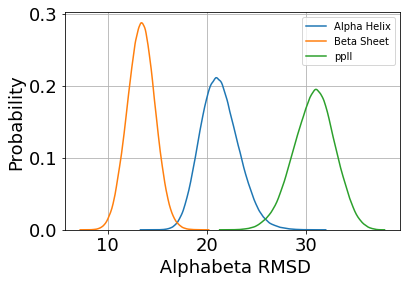

<Figure size 432x288 with 0 Axes>

In [10]:
def alphabeta_rmsd(phi, psi, phi_ref, psi_ref):
    alphabetarmsd = np.sum(0.5*(1+np.cos(psi-psi_ref)),
                           axis=1)+np.sum(0.5*(1+np.cos(phi-phi_ref)), axis=1)
    return alphabetarmsd


Phi_all = phis
Psi_all = psis
alphabeta_alpharight = alphabeta_rmsd(Phi_all, Psi_all, -1.05, -0.79)
alphabeta_betasheet = alphabeta_rmsd(Phi_all, Psi_all, 2.36, -2.36)
alphabeta_ppII = alphabeta_rmsd(Phi_all, Psi_all, -1.31, 2.71)

sns.kdeplot(data=alphabeta_alpharight, label='Alpha Helix')
sns.kdeplot(data=alphabeta_betasheet, label='Beta Sheet')
sns.kdeplot(data=alphabeta_ppII, label='ppII')

plt.xlabel(' Alphabeta RMSD', fontsize=18)
#plt.xlim(20, 100)
#plt.ylim(0, 0.15)

plt.ylabel('Probability', fontsize=18)
plt.legend(loc='upper right')
plt.tick_params(labelsize=18)

plt.grid()

plt.show()
plt.savefig(out_dir+'Alphabeta.histogram.png')

In [13]:
alphabeta_ppII

array([29.003963, 28.875746, 28.740108, ..., 32.79336 , 33.73739 ,
       31.87704 ], dtype=float32)

In [16]:
np.savetxt(out_dir+'phipsi.dat',np.column_stack((alphabeta_alpharight, alphabeta_betasheet, alphabeta_ppII)))

In [7]:
def add_charge_pair(pairs,pos,neg,contact_prob):
    if pos not in pairs: 
        pairs[pos] = {} 
    if neg not in pairs[pos]:
        pairs[pos][neg] = {}
    pairs[pos][neg] = contact_prob

#Select Protein Charge Groups
#Add Apropriate HIS name if there is a charged HIE OR HIP in the structure 
Protein_Pos_Charges=top.select("(resname ARG and name CZ) or (resname LYS and name NZ) or (resname HIE and name NE2) or (resname HID and name ND1)")
#Protein_Neg_Charges=[]
Protein_Neg_Charges=top.select("(resname ASP and name CG) or (resname GLU and name CD) or (name OXT) or (resname NASP and name CG)")
neg_res=[]
pos_res=[]
                               
for i in Protein_Neg_Charges:
    neg_res.append(top.atom(i).residue.resSeq)

for i in Protein_Pos_Charges:
    pos_res.append(top.atom(i).residue.resSeq)                               
                               
print("Negatively Charged Residues:", neg_res)
print("Posiitively Charged Residues", pos_res)

Negatively Charged Residues: [121, 123, 126, 130, 131, 135, 137, 139, 140]
Posiitively Charged Residues []


In [8]:
charge_pairs_ligpos=[]                      
for i in Ligand_Pos_Charges:
    for j in Protein_Neg_Charges:              
        charge_pairs_ligpos.append([i,j])
        pos=top.atom(i)
        neg=top.atom(j) 

charge_pairs_ligneg=[]                      
for i in Ligand_Neg_Charges:
    for j in Protein_Pos_Charges:              
        charge_pairs_ligneg.append([i,j])
        pos=top.atom(i)
        neg=top.atom(j) 

if len(charge_pairs_ligpos) != 0:
    contact  = md.compute_distances(trj, charge_pairs_ligpos)
    contacts = np.asarray(contact).astype(float)
    cutoff=0.5
    neg_res_contact_frames=np.where(contacts < 0.5, 1, 0)
    contact_prob_ligpos = np.sum(neg_res_contact_frames,axis=0)/trj.n_frames

if len(charge_pairs_ligneg) != 0:
    contact  = md.compute_distances(trj, charge_pairs_ligneg)
    contacts = np.asarray(contact).astype(float)
    cutoff=0.5
    pos_res_contact_frames=np.where(contacts < 0.5, 1, 0)
    contact_prob_ligneg = np.sum(pos_res_contact_frames,axis=0)/trj.n_frames

charge_pair_names={}
for i in range(0,len(charge_pairs_ligpos)):
    pos=top.atom(charge_pairs_ligpos[i][0])
    neg=top.atom(charge_pairs_ligpos[i][1])      
    add_charge_pair(charge_pair_names,pos,neg,contact_prob_ligpos[i])

for i in range(0,len(charge_pairs_ligneg)):
    pos=top.atom(charge_pairs_ligneg[i][1])
    neg=top.atom(charge_pairs_ligneg[i][0])      
    add_charge_pair(charge_pair_names,pos,neg,contact_prob_ligneg[i])

print(charge_pair_names)


{<1>1-N: {ASP121-CG: 0.016415681494730796, GLU123-CD: 0.028618520842316378, GLU126-CD: 0.03540407727504728, GLU130-CD: 0.03536356917747858, GLU131-CD: 0.03350109686926417, ASP135-CG: 0.08027084614214382, GLU137-CD: 0.04715232574991741, GLU139-CD: 0.037456487551861616, ALA140-OXT: 0.05094928476202393}}


In [13]:
residues=21
residue_offset=121
residue_number = range(residue_offset, residue_offset+residues)
neg_res_index=np.array(neg_res)-residue_offset
Charge_Contacts=np.zeros((trj.n_frames,residues))

for i in range(0,len(neg_res)):
    Charge_Contacts[:,neg_res[i]-residue_offset]=neg_res_contact_frames[:,i]

charge_contact_fraction,charge_contact_fraction_be=get_blockerrors_pyblock(Charge_Contacts,1.0)
np.savetxt(out_dir+'charge_contacts.traj.dat', Charge_Contacts,'%i')
np.savetxt(out_dir+'charge_contacts.dat',np.column_stack((residue_number, charge_contact_fraction,
                                                          charge_contact_fraction_be)),fmt='%.4f')

charge_by_res=np.column_stack((residue_number, charge_contact_fraction))
#print(charge_by_res)


np.savetxt(out_dir+'charge_contacts.BF.dat',
           np.column_stack((residue_number, charge_contact_fraction/boundfrac,
                            charge_contact_fraction_be/boundfrac)),fmt='%.4f')

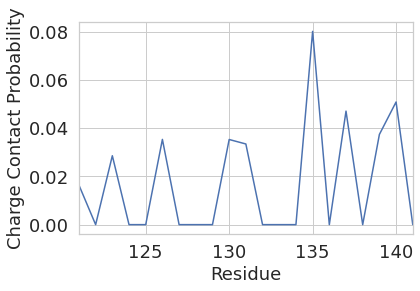

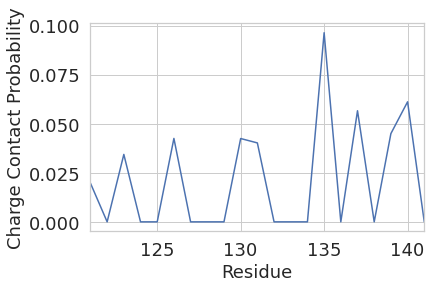

In [15]:

plt.plot(residue_number,charge_contact_fraction)
plt.xlabel('Residue', size=18)
plt.ylabel('Charge Contact Probability', size=18)
plt.tick_params(labelsize=18)
plt.xlim(residue_offset, residue_offset+residues-1)
plt.tight_layout()
#plt.savefig('ChargeContactFraction.png')
#plt.clf()
plt.show()

plt.plot(residue_number,charge_contact_fraction/boundfrac)
plt.xlabel('Residue', size=18)
plt.ylabel('Charge Contact Probability', size=18)
plt.tick_params(labelsize=18)
plt.xlim(residue_offset, residue_offset+residues-1)
plt.tight_layout()
#plt.savefig('ChargeContactFraction.0.7325bf.png')

In [16]:
ligand_hphob = top.select("resid 21 and element C")
protein_hphob = top.select("resid 0 to 20 and element C and not name CA")


ligand_hphob_atoms = []
for atom in ligand_hphob:
    ligand_hphob_atoms.append(top.atom(atom))

protein_hphob_atoms = []
for atom in protein_hphob:
    protein_hphob_atoms.append(top.atom(atom))

#print(ligand_hphob)
#print(ligand_hphob_atoms)

def add_contact_pair(pairs, a1, a2, a1_id, a2_id, prot_res, contact_prob):
    if prot_res not in pairs:
        pairs[prot_res] = {}
    if a2 not in pairs[prot_res]:
        pairs[prot_res][a2] = {}
    if a1_id not in pairs[prot_res][a2]:
        pairs[prot_res][a2][a1_id] = contact_prob


hphob_pairs = []
for i in ligand_hphob:
    for j in protein_hphob:
        hphob_pairs.append([i, j])


contact = md.compute_distances(trj, hphob_pairs)
contacts = np.asarray(contact).astype(float)
cutoff = 0.4
contact_frames = np.where(contacts < cutoff, 1, 0)
contact_prob_hphob = np.sum(contact_frames, axis=0)/trj.n_frames


# Hphob Contacts at Atom Pair Resolution
hphob_pair_names = {}
for i in range(0, len(hphob_pairs)):
    a1_id = hphob_pairs[i][0]
    a2_id = hphob_pairs[i][1]
    a1 = top.atom(hphob_pairs[i][0])
    a2 = top.atom(hphob_pairs[i][1])
    prot_res = top.atom(hphob_pairs[i][1]).residue.resSeq
    add_contact_pair(hphob_pair_names, a1, a2, a1_id,
                     a2_id, prot_res, contact_prob_hphob[i])

#residue_number = range(residue_offset, residue_offset+residues)
hphob_max_contacts = {}

# Print Most Populated Contact For Each Aliphatic Carbon in the protein
for i in range(121,141):
    if i in hphob_pair_names.keys():
        maxi = 0
        for j in hphob_pair_names[i]:
            max_contact_j = max(
                hphob_pair_names[i][j], key=hphob_pair_names[i][j].get)
            max_contact_fraction = hphob_pair_names[i][j][max_contact_j]
            if max_contact_fraction > maxi:
                max_key_j = j
                max_j_subkey = max_contact_j
                maxi = max_contact_fraction
        hphob_max_contacts[i] = [max_key_j, max_j_subkey, top.atom(
            max_j_subkey), hphob_pair_names[i][max_key_j][max_j_subkey]]




# print("Most Populatd Hydrophobic Contact by Residue:")
# for i in hphob_max_contacts:
#     print(hphob_max_contacts[i])

# Cast hydrophobic contacts as per residue in each frame
# Cast hydrophobic contacts as per residue in each frame
residues = 21
residue_offset = 121
residue_number = range(0, residues)
residue_number_offset = range(residue_offset, residue_offset+residues)


Hphob_res_contacts = np.zeros((trj.n_frames, residues))
for frame in range(trj.n_frames):
    if np.sum(contact_frames[frame]) > 0:
        contact_pairs = np.where(contact_frames[frame] == 1)
        for j in contact_pairs[0]:
            residue = top.atom(hphob_pairs[j][1]).residue.resSeq
            Hphob_res_contacts[frame][residue-121] = 1


np.savetxt(out_dir+'hphob_contacts.traj.dat', Hphob_res_contacts, '%i')
hphob_ave, hphob_pyb_be = get_blockerrors_pyblock(Hphob_res_contacts, 1.0)
hphob_by_res = np.column_stack(
    (residue_number_offset, hphob_ave, hphob_pyb_be))
np.savetxt(out_dir+'hphob_contacts.be.dat', hphob_by_res)

hphob_by_res_boundfraction = np.column_stack((residue_number_offset,hphob_by_res[:, 1]/boundfrac, hphob_by_res[:, 2]/boundfrac))

np.savetxt(out_dir+'hphob_contacts.BF.dat', hphob_by_res_boundfraction, fmt='%.4f')


In [17]:
n_frames=trj.n_frames

In [18]:
n_rings = len(ligand_rings)
print("Ligand Aromatics Rings:", n_rings)

ligand_ring_params = []
for i in range(0, n_rings):
    ring = np.array(ligand_rings[i])
    print(ring)
    positions = trj.xyz[:, ring, :]
    print(ligand_rings[i][0], ligand_rings[i][1], ligand_rings[i][2])
    ligand_centers_normals = get_ring_center_normal_trj_assign_atomid(
        positions, 0, 1, 2)
    ligand_ring_params.append(ligand_centers_normals)


#Find Protein Aromatic Rings
#Add Apropriate HIS name if there is a charged HIE OR HIP in the structure 
prot_rings = []
aro_residues = []
prot_ring_name = []
prot_ring_index = []

aro_select = top.select("resname TYR PHE HIS TRP and name CA")
for i in aro_select:
    atom = top.atom(i)
    resname = atom.residue.name
    print(atom.index, atom.name, atom.residue.name,
          atom.residue, atom.residue.index)
    if resname == "TYR":
        ring = top.select(
            "resid %s and name CG CD1 CD2 CE1 CE2 CZ" % atom.residue.index)
        print(atom.residue, ring)
    if resname == "TRP":
        ring = top.select(
            "resid %s and name CG CD1 NE1 CE2 CD2 CZ2 CE3 CZ3 CH2" % atom.residue.index)
        print(atom.residue, ring)
    if resname == "HIS":
        ring = top.select("resid %s and name CG ND1 CE1 NE2 CD2" %
                          atom.residue.index)
        print(atom.residue, ring)
    if resname == "PHE":
        ring = top.select(
            "resid %s and name CG CD1 CD2 CE1 CE2 CZ" % atom.residue.index)
        print(atom.residue, ring)
    prot_rings.append(ring)
    prot_ring_name.append(atom.residue)
    prot_ring_index.append(atom.residue.index+residue_offset)


print("Protein Aromatics Rings:", len(prot_rings), prot_ring_name)

prot_ring_params = []
for i in range(0, len(prot_rings)):
    ring = np.array(prot_rings[i])
    positions = trj.xyz[:, ring, :]
    ring_centers_normals = get_ring_center_normal_trj_assign_atomid(
        positions, 0, 1, 2)
    prot_ring_params.append(ring_centers_normals)

Ligand Aromatics Rings: 1
[307 308 309 311 313 314]
307 308 309
() (1110889, 3) (1110889, 3)
52 CA TYR TYR125 4
TYR125 [56 57 58 59 60 61]
167 CA TYR TYR133 12
TYR133 [171 172 173 174 175 176]
217 CA TYR TYR136 15
TYR136 [221 222 223 224 225 226]
Protein Aromatics Rings: 3 [TYR125, TYR133, TYR136]
() (1110889, 3) (1110889, 3)
() (1110889, 3) (1110889, 3)
() (1110889, 3) (1110889, 3)


In [19]:
frames = n_frames
sidechains = len(prot_rings)
ligrings = len(ligand_rings)
print(frames, sidechains)
Ringstacked_old = {}
Ringstacked = {}
Quadrants = {}
Stackparams = {}
Aro_Contacts = {}
Pstack = {}
Tstack = {}


def normvector_connect(point1, point2):
    vec = point1-point2
    vec = vec/np.sqrt(np.dot(vec, vec))
    return vec


def angle(v1, v2):
    return np.arccos(np.dot(v1, v2)/(np.sqrt(np.dot(v1, v1))*np.sqrt(np.dot(v2, v2))))

'''
print("q1: alpha<=45 and beta>=135")
print("q2: alpha>=135 and beta>=135")
print("q3: alpha<=45 and beta<=45")
print("q4: alpha>=135 and beta<=135")
'''

for l in range(0, ligrings):
    name = "Lig_ring.%s" % l
    print(name)
    Stackparams[name] = {}
    Pstack[name] = {}
    Tstack[name] = {}
    Aro_Contacts[name] = {}
    alphas = np.zeros(shape=(frames, sidechains))
    betas = np.zeros(shape=(frames, sidechains))
    dists = np.zeros(shape=(frames, sidechains))
    thetas = np.zeros(shape=(frames, sidechains))
    phis = np.zeros(shape=(frames, sidechains))
    pstacked_old = np.zeros(shape=(frames, sidechains))
    pstacked = np.zeros(shape=(frames, sidechains))
    tstacked = np.zeros(shape=(frames, sidechains))
    stacked = np.zeros(shape=(frames, sidechains))
    aro_contacts = np.zeros(shape=(frames, sidechains))
    quadrant=np.zeros(shape=(frames,sidechains))

    for i in range(0, frames):
        ligcenter = ligand_ring_params[l][i][0]
        lignormal = ligand_ring_params[l][i][1]
        for j in range(0, sidechains):
            protcenter = prot_ring_params[j][i][0]
            protnormal = prot_ring_params[j][i][1]
            dists[i, j] = np.linalg.norm(ligcenter-protcenter)
            connect = normvector_connect(protcenter, ligcenter)
            # alpha is the same as phi in gervasio/Procacci definition
            alphas[i, j] = np.rad2deg(angle(connect, protnormal))
            betas[i, j] = np.rad2deg(angle(connect, lignormal))
            theta = np.rad2deg(angle(protnormal, lignormal))
            thetas[i, j] = np.abs(theta)-2*(np.abs(theta)
                                            > 90.0)*(np.abs(theta)-90.0)
            phi = np.rad2deg(angle(protnormal, connect))
            phis[i, j] = np.abs(phi)-2*(np.abs(phi) > 90.0)*(np.abs(phi)-90.0)

    for j in range(0, sidechains):
        name2 = prot_ring_index[j]
        res2 = prot_ring_name[j]
        print('====>',name2, res2)
        Ringstack = np.column_stack((dists[:, j], alphas[:, j], betas[:, j], thetas[:, j], phis[:, j]))
        stack_distance_cutoff = 0.65
        r = np.where(dists[:, j] <= stack_distance_cutoff)[0]
        aro_contacts[:, j][r] = 1

        # New Definitions
        # p-stack: r < 6.5 Å, θ < 60° and ϕ < 60°.
        # t-stack: r < 7.5 Å, 75° < θ < 90° and ϕ < 60°.
        p_stack_distance_cutoff = 0.65
        t_stack_distance_cutoff = 0.75
        r_pstrict = np.where(dists[:, j] <= p_stack_distance_cutoff)[0]
        r_tstrict = np.where(dists[:, j] <= t_stack_distance_cutoff)[0]
        
        a=np.where(alphas[:,j] >= 135)
        b=np.where(alphas[:,j] <= 45)
        c=np.where(betas[:,j] >= 135)
        d=np.where(betas[:,j] <= 45)
        e=np.where(dists[:,j] <= 0.5)
        q1=np.intersect1d(np.intersect1d(b,c),e)
        q2=np.intersect1d(np.intersect1d(a,c),e)
        q3=np.intersect1d(np.intersect1d(b,d),e)
        q4=np.intersect1d(np.intersect1d(a,d),e)
        stacked[:,j][q1]=1
        stacked[:,j][q2]=1
        stacked[:,j][q3]=1
        stacked[:,j][q4]=1
        quadrant[:,j][q1]=1
        quadrant[:,j][q2]=2
        quadrant[:,j][q3]=3
        quadrant[:,j][q4]=4
        total_stacked=len(q1)+len(q2)+len(q3)+len(q4)
        print("q1:",len(q1),"q2:",len(q2),"q3:",len(q3),"q4:",len(q4))
        print("q1:",len(q1)/total_stacked,"q2:",len(q2)/total_stacked,"q3:",len(q3)/total_stacked,"q4:",len(q4)/total_stacked)
        print(max(len(q1),len(q2),len(q3),len(q4))/min(len(q1),len(q2),len(q3),len(q4)))
        #print(Ringstack)
        Stackparams[name][name2]=Ringstack
        print(np.average(Ringstack,axis=0))
        
        
        f = np.where(thetas[:, j] <= 45)
        g = np.where(phis[:, j] <= 60)
        h = np.where(thetas[:, j] >= 75)

        pnew = np.intersect1d(np.intersect1d(f, g), r_pstrict)
        tnew = np.intersect1d(np.intersect1d(h, g), r_tstrict)
        pstacked[:, j][pnew] = 1
        tstacked[:, j][tnew] = 1
        stacked[:, j][pnew] = 1
        stacked[:, j][tnew] = 1
        total_stacked = len(pnew)+len(tnew)
        print("===>Contacts:", len(r), "Total:", total_stacked,
              "P-stack:", len(pnew), "T-stack:", len(tnew))
        Stackparams[name][name2] = Ringstack
    Pstack[name] = pstacked
    Tstack[name] = tstacked
    Aro_Contacts[name] = aro_contacts
    Ringstacked[name] = stacked
#    Ringstacked[name]=stacked
    Quadrants[name]=quadrant  
#    Ringstacked[name]=stacked
#    print(np.average(Ringstacked[name],axis=0))

1110889 3
Lig_ring.0
====> 125 TYR125
q1: 14058 q2: 15168 q3: 16371 q4: 16338
q1: 0.2269798982804553 q2: 0.24490191329619762 q3: 0.26432550254298864 q4: 0.2637926858803584
1.1645326504481435
[ 1.79296842 89.56329244 88.72379386 53.16524555 55.18233361]
===>Contacts: 155525 Total: 121000 P-stack: 110575 T-stack: 10425
====> 133 TYR133
q1: 17443 q2: 14598 q3: 15351 q4: 13240
q1: 0.28768637023354005 q2: 0.24076395302810397 q3: 0.2531831376170999 q4: 0.21836653912125611
1.3174471299093655
[ 1.49214071 89.38421128 89.76904785 52.19129436 53.64655204]
===>Contacts: 211100 Total: 157886 P-stack: 137943 T-stack: 19943
====> 136 TYR136
q1: 15192 q2: 18807 q3: 17444 q4: 17958
q1: 0.21890174493162923 q2: 0.27099033155141855 q3: 0.2513508450886875 q4: 0.25875707842826473
1.237954186413902
[ 1.59751444 90.42089215 89.0523821  51.81952764 53.76381139]
===>Contacts: 193670 Total: 148931 P-stack: 134986 T-stack: 13945


/tmp/ipykernel_18819/3499030188.py:4: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  H125=ax[0,0].hist2d(Stackparams['Lig_ring.0'][125][:,1][contact],Stackparams['Lig_ring.0'][125][:,2][contact], bins=36,range=[[0,180],[0,180]], norm=colors.LogNorm(),cmap='jet')
/tmp/ipykernel_18819/3499030188.py:9: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  H133=ax[0,1].hist2d(Stackparams['Lig_ring.0'][133][:,1][contact],Stackparams['Lig_ring.0'][133][:,2][contact], bins=36,range=[[0,180],[0,180]], norm=colors.LogNorm(),cmap='jet')
/tmp/ipykernel_18819/3499030188.py:14: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please cal

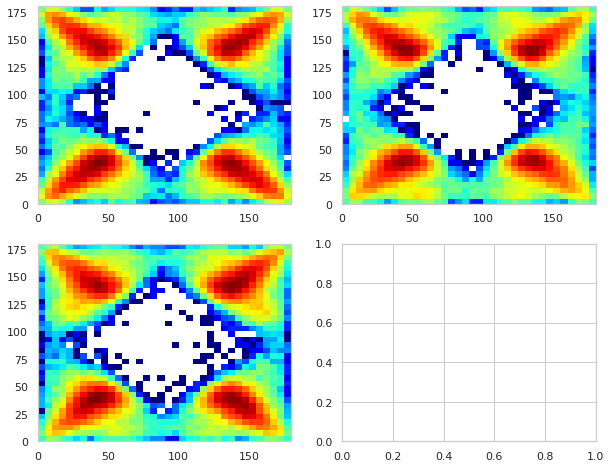

In [20]:


fig, ax = plt.subplots(2,2,figsize=((10,8)))

contact=np.where(Stackparams['Lig_ring.0'][125][:,0]<= 0.5)
H125=ax[0,0].hist2d(Stackparams['Lig_ring.0'][125][:,1][contact],Stackparams['Lig_ring.0'][125][:,2][contact], bins=36,range=[[0,180],[0,180]], norm=colors.LogNorm(),cmap='jet')
# np.savetxt(outdir+'Lig_ring.0.Y125.stackparams.all.dat',Stackparams['Lig_ring.0'][125],fmt='%.4f')
# np.savetxt(outdir+'Lig_ring.0.Y125.stackparams.dist_lt_0.5.dat',Stackparams['Lig_ring.0'][125][contact],fmt='%.4f')

contact=np.where(Stackparams['Lig_ring.0'][133][:,0]<= 0.5)
H133=ax[0,1].hist2d(Stackparams['Lig_ring.0'][133][:,1][contact],Stackparams['Lig_ring.0'][133][:,2][contact], bins=36,range=[[0,180],[0,180]], norm=colors.LogNorm(),cmap='jet')
# np.savetxt(outdir+'Lig_ring.0.Y133.stackparams.all.dat',Stackparams['Lig_ring.0'][133],fmt='%.4f')
# np.savetxt(outdir+'Lig_ring.0.Y133.stackparams.dist_lt_0.5.dat',Stackparams['Lig_ring.0'][133][contact],fmt='%.4f')

contact=np.where(Stackparams['Lig_ring.0'][136][:,0]<= 0.5)
H136=ax[1,0].hist2d(Stackparams['Lig_ring.0'][136][:,1][contact],Stackparams['Lig_ring.0'][136][:,2][contact], bins=36,range=[[0,180],[0,180]], norm=colors.LogNorm(),cmap='jet')
# np.savetxt(outdir+'Lig_ring.0.Y136.stackparams.all.dat',Stackparams['Lig_ring.0'][136],fmt='%.4f')
# np.savetxt(outdir+'Lig_ring.0.Y136.stackparams.dist_lt_0.5.dat',Stackparams['Lig_ring.0'][136][contact],fmt='%.4f')


#plt.savefig(outdir+'StackingHistograms.png')
plt.show()

In [21]:
residues = 21
residue_offset = 121
residue_number = range(residue_offset, residue_offset+residues)
aro_res_index = np.array(prot_ring_index)-residue_offset

aromatic_stacking_contacts_r0 = np.zeros((n_frames, residues))

aromatic_contacts_r0 = np.zeros((n_frames, residues))

#print(aro_res_index)

for i in range(0, len(aro_res_index)):
    aromatic_stacking_contacts_r0[:, aro_res_index[i]
                                  ] = Ringstacked['Lig_ring.0'][:, i]
    aromatic_contacts_r0[:, aro_res_index[i]
                         ] = Aro_Contacts['Lig_ring.0'][:, i]


np.savetxt(out_dir+'aromatic_stacking.traj.r0.dat',
           aromatic_stacking_contacts_r0, '%i')
aro_r0_ave, aro_r0_pyb_be = get_blockerrors_pyblock(
    aromatic_stacking_contacts_r0, 1.0)
aro_r0_by_res = np.column_stack(
    (residue_number_offset, aro_r0_ave, aro_r0_pyb_be))
np.savetxt(out_dir+'aromatic_stacking.fraction.r0.be.dat', aro_r0_by_res)

aro_r0_by_res_bf = np.column_stack(
    (residue_number_offset, aro_r0_ave/boundfrac, aro_r0_pyb_be/boundfrac))
np.savetxt(out_dir+'aromatic_stacking.boundfraction.r0.be.dat', aro_r0_by_res_bf)

In [22]:
# Select Ligand Residues
ligand = top.select("resid 21")
# Select Protein Residues
protein = top.select("resid 0 to 20")

residues=21

HBond_PD = np.zeros((n_frames, residues))
HBond_LD = np.zeros((n_frames, residues))
Hbond_pairs_PD = {}
Hbond_pairs_LD = {}


def add_hbond_pair(donor, acceptor, hbond_pairs, donor_res):
    if donor_res not in hbond_pairs:
        hbond_pairs[donor_res] = {}
    if donor not in hbond_pairs[donor_res]:
        hbond_pairs[donor_res][donor] = {}
    if acceptor not in hbond_pairs[donor_res][donor]:
        hbond_pairs[donor_res][donor][acceptor] = 0
    hbond_pairs[donor_res][donor][acceptor] += 1

# Donor & Acceptors Definitions from DESRES paper:
# ligdon = mol.select('chain B and (nitrogen or oxygen or sulfur) and (withinbonds 1 of hydrogen)')
# ligacc = mol.select('chain B and (nitrogen or oxygen or sulfur)')
# protdon = mol.select('chain A and (nitrogen or oxygen or sulfur) and (withinbonds 1 of hydrogen)')
# protacc = mol.select('chain A and (nitrogen or oxygen or sulfur)')


for frame in range(n_frames):
    hbonds = baker_hubbard2(trj[frame], angle_cutoff=150,
                            distance_cutoff=0.35, lig_donor_index=lig_hbond_donors)
    for hbond in hbonds:
        if ((hbond[0] in protein) and (hbond[2] in ligand)):
            donor = top.atom(hbond[0])
            donor_id = hbond[0]
            donor_res = top.atom(hbond[0]).residue.resSeq
            acc = top.atom(hbond[2])
            acc = top.atom(hbond[2])
            acc_res = top.atom(hbond[2]).residue.resSeq
            HBond_PD[frame][donor_res-121] = 1
            add_hbond_pair(donor, acc, Hbond_pairs_PD, donor_res)
        if ((hbond[0] in ligand) and (hbond[2] in protein)):
            donor = top.atom(hbond[0])
            donor_id = hbond[0]
            donor_res = top.atom(hbond[0]).residue.resSeq
            acc = top.atom(hbond[2])
            acc_id = hbond[2]
            acc_res = top.atom(hbond[2]).residue.resSeq
            HBond_LD[frame][acc_res-121] = 1
            add_hbond_pair(donor, acc, Hbond_pairs_LD, acc_res)

In [23]:
residues = 21
residue_offset = 121
residue_number = range(residue_offset, residue_offset+residues)

residue_number_offset = range(residue_offset, residue_offset+residues)

HB_Total = HBond_PD+HBond_LD
HB_Total_ave = np.mean(HB_Total, axis=0)


PD_ave = np.mean(HBond_PD, axis=0)
LD_ave = np.mean(HBond_LD, axis=0)
for i in Hbond_pairs_PD:
    print(i, i+residue_offset, Hbond_pairs_PD[i])

print("HBond_Ligand Donors")

for i in Hbond_pairs_LD:
    print(i, Hbond_pairs_LD[i])

np.savetxt(out_dir+'Hbond.PD.traj.dat', HBond_PD, '%i')
np.savetxt(out_dir+'Hbond.LD.traj.dat', HBond_LD, '%i')
np.savetxt(out_dir+'Hbond.all.traj.dat', HB_Total, '%i')
hbond_by_res = np.column_stack((residue_number, HB_Total_ave))
hbond_by_res_PD = np.column_stack((residue_number, PD_ave))
hbond_by_res_LD = np.column_stack((residue_number, LD_ave))


HBond_PD_ave, HBond_PD_pyb_be = get_blockerrors_pyblock(HBond_PD, 1.0)
HBond_LD_ave, HBond_LD_pyb_be = get_blockerrors_pyblock(HBond_LD, 1.0)
HBond_ave, HBond_pyb_be = get_blockerrors_pyblock(HB_Total, 1.0)

Hbond_by_res = np.column_stack(
    (residue_number_offset, HBond_ave, HBond_pyb_be))
Hbond_by_res_bf = np.column_stack(
    (residue_number_offset, HBond_ave/boundfrac, HBond_pyb_be/boundfrac))
np.savetxt(out_dir+'hbond_fraction.be.dat', Hbond_by_res)
np.savetxt(out_dir+'hbond_fraction.boundfraction.be.dat', Hbond_by_res_bf)


Hbond_by_res_LD = np.column_stack(
    (residue_number_offset, HBond_LD_ave, HBond_LD_pyb_be))
np.savetxt(out_dir+'hbond_fraction.PD.be.dat', Hbond_by_res_LD)
Hbond_by_res_LD_bf = np.column_stack(
    (residue_number_offset, HBond_LD_ave/boundfrac, HBond_LD_pyb_be/boundfrac))
np.savetxt(out_dir+'hbond_fraction.PD.boundfraction.be.dat', Hbond_by_res_LD_bf)


Hbond_by_res_PD = np.column_stack(
    (residue_number_offset, HBond_PD_ave, HBond_PD_pyb_be))
np.savetxt(out_dir+'hbond_fraction.LD.be.dat', Hbond_by_res_PD)
Hbond_by_res_PD_bf = np.column_stack(
    (residue_number_offset, HBond_PD_ave/boundfrac, HBond_PD_pyb_be/boundfrac))
np.savetxt(out_dir+'hbond_fraction.PD.boundfraction.be.dat', Hbond_by_res_PD_bf)

127 248 {MET127-N: {<1>1-S: 3687, <1>1-O: 3273, <1>1-O: 2943, <1>1-O: 1927, <1>1-N: 160, <1>1-N: 14, <1>1-N: 33}}
126 247 {GLU126-N: {<1>1-S: 7411, <1>1-O: 4587, <1>1-O: 4926, <1>1-N: 175, <1>1-O: 1896, <1>1-N: 111, <1>1-N: 38}}
125 246 {TYR125-OH: {<1>1-O: 619, <1>1-O: 551, <1>1-S: 627, <1>1-O: 434, <1>1-N: 10, <1>1-N: 74, <1>1-N: 2}, TYR125-N: {<1>1-S: 2192, <1>1-O: 1868, <1>1-O: 1609, <1>1-N: 27, <1>1-O: 1473, <1>1-N: 172, <1>1-N: 14}}
121 242 {ASP121-N: {<1>1-N: 152, <1>1-S: 380, <1>1-O: 243, <1>1-O: 131, <1>1-O: 177, <1>1-N: 5, <1>1-N: 7}}
136 257 {TYR136-OH: {<1>1-O: 706, <1>1-S: 517, <1>1-O: 380, <1>1-N: 89, <1>1-O: 502, <1>1-N: 8, <1>1-N: 3}, TYR136-N: {<1>1-O: 1842, <1>1-N: 259, <1>1-O: 10412, <1>1-N: 250, <1>1-S: 6143, <1>1-O: 1548, <1>1-N: 15}}
129 250 {SER129-N: {<1>1-O: 1199, <1>1-S: 1898, <1>1-O: 1410, <1>1-N: 309, <1>1-O: 1488, <1>1-N: 87, <1>1-N: 41}, SER129-OG: {<1>1-O: 548, <1>1-O: 622, <1>1-S: 1361, <1>1-N: 35, <1>1-O: 1305, <1>1-N: 46, <1>1-N: 13}}
140 261 {ALA140-N

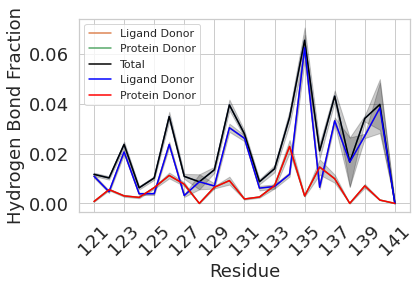

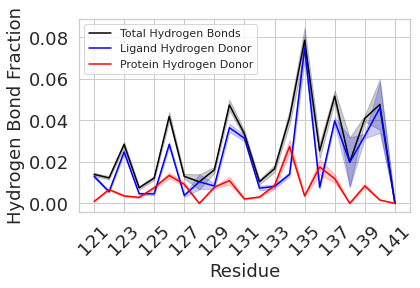

<Figure size 432x288 with 0 Axes>

In [24]:
residue_number = range(residue_offset, residue_offset+residues)
#plt.figure(figsize=(8,8))
plt.plot(residue_number, HB_Total_ave)
plt.plot(residue_number, LD_ave, label="Ligand Donor")
plt.plot(residue_number, PD_ave, label="Protein Donor")


plt.plot(Hbond_by_res[:, 0], Hbond_by_res[:, 1], color='black', label='Total')
plt.fill_between(Hbond_by_res[:, 0], Hbond_by_res[:, 1]+Hbond_by_res[:, 2],
                 Hbond_by_res[:, 1]-Hbond_by_res[:, 2], color='black', alpha=0.2)
plt.plot(Hbond_by_res_LD[:, 0], Hbond_by_res_LD[:, 1],
         color='blue', label='Ligand Donor')
plt.fill_between(Hbond_by_res_LD[:, 0], Hbond_by_res_LD[:, 1]+Hbond_by_res_LD[:, 2],
                 Hbond_by_res_LD[:, 1]-Hbond_by_res_LD[:, 2], color='black', alpha=0.2)
plt.plot(Hbond_by_res_PD[:, 0], Hbond_by_res_PD[:, 1],
         color='red', label='Protein Donor')
plt.fill_between(Hbond_by_res_PD[:, 0], Hbond_by_res_PD[:, 1]+Hbond_by_res_PD[:, 2],
                 Hbond_by_res_PD[:, 1]-Hbond_by_res_PD[:, 2], color='black', alpha=0.2)


plt.legend()
#plt.ylim(0, 0.10)
plt.xlabel('Residue', size=18)
plt.ylabel('Hydrogen Bond Fraction', size=18)
plt.tick_params(labelsize=18)
plt.xticks(np.arange(121,142,2),rotation=45)
plt.tight_layout()
plt.savefig(out_dir+'HbondFraction.allframes.pdf')
plt.show()
plt.clf()

#plt.figure(figsize=(10,8))
plt.plot(Hbond_by_res_bf[:, 0], Hbond_by_res_bf[:, 1],
         color='black', label='Total Hydrogen Bonds')
plt.fill_between(Hbond_by_res_bf[:, 0], Hbond_by_res_bf[:, 1]+Hbond_by_res_bf[:, 2],
                 Hbond_by_res_bf[:, 1]-Hbond_by_res_bf[:, 2], color='black', alpha=0.2)
plt.plot(Hbond_by_res_LD_bf[:, 0], Hbond_by_res_LD_bf[:,
         1], color='blue', label='Ligand Hydrogen Donor')
plt.fill_between(Hbond_by_res_LD_bf[:, 0], Hbond_by_res_LD_bf[:, 1]+Hbond_by_res_LD_bf[:, 2],
                 Hbond_by_res_LD_bf[:, 1]-Hbond_by_res_LD_bf[:, 2], color='blue', alpha=0.2)
plt.plot(Hbond_by_res_PD_bf[:, 0], Hbond_by_res_PD_bf[:,
         1], color='red', label='Protein Hydrogen Donor')
plt.fill_between(Hbond_by_res_PD_bf[:, 0], Hbond_by_res_PD_bf[:, 1]+Hbond_by_res_PD_bf[:, 2],
                 Hbond_by_res_PD_bf[:, 1]-Hbond_by_res_PD_bf[:, 2], color='red', alpha=0.2)


plt.legend()
plt.xlabel('Residue', size=18)
plt.ylabel('Hydrogen Bond Fraction', size=18)
#plt.ylim(0, 0.10)
plt.tick_params(labelsize=18)
plt.xticks(np.arange(121,142,2),rotation=45)
plt.tight_layout()
plt.savefig(out_dir+'HbondFraction.boundfraction.pdf')
plt.show()
plt.clf()

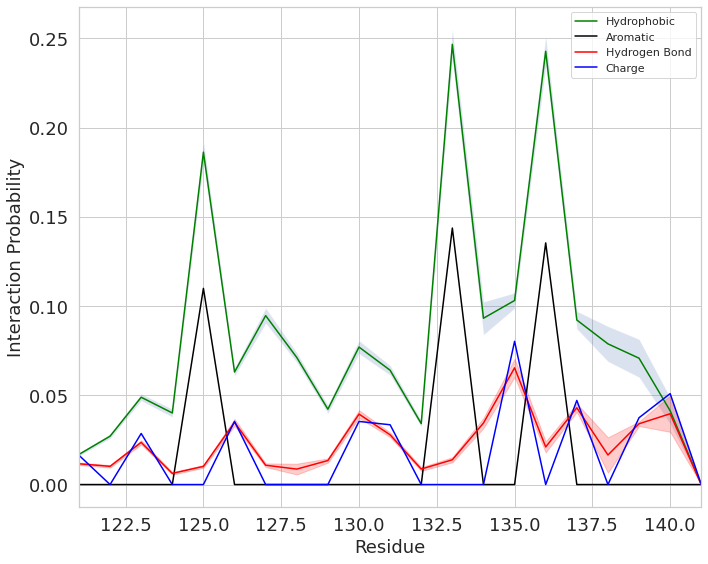

<Figure size 432x288 with 0 Axes>

In [25]:

plt.figure(figsize=(10,8))
plt.plot(residue_number_offset,
         hphob_by_res[:, 1], label='Hydrophobic', color='green')
plt.fill_between(residue_number_offset,
                 hphob_by_res[:, 1]+hphob_by_res[:, 2], hphob_by_res[:, 1]-hphob_by_res[:, 2], alpha=0.2)

plt.plot(aro_r0_by_res[:, 0], aro_r0_by_res[:, 1], color='black', label='Aromatic')
plt.fill_between(aro_r0_by_res[:, 0]+121, aro_r0_by_res[:, 1]+aro_r0_by_res[:, 2],
                 aro_r0_by_res[:, 1]-aro_r0_by_res[:, 2], color='black', alpha=0.2)

plt.plot(Hbond_by_res[:, 0], Hbond_by_res[:, 1],
         label='Hydrogen Bond', color='red')
plt.fill_between(Hbond_by_res[:, 0], Hbond_by_res[:, 1]+Hbond_by_res[:, 2],
                 Hbond_by_res[:, 1]-Hbond_by_res[:, 2], color='red', alpha=0.2)

plt.plot(Hbond_by_res[:, 0],charge_contact_fraction,label='Charge',c='blue')


plt.xlabel('Residue', size=18)
plt.ylabel('Interaction Probability', size=18)
plt.tick_params(labelsize=18)
plt.xlim(residue_offset, residue_offset+residues-1)
plt.legend()
plt.tight_layout()
plt.savefig(out_dir+'LigandInteractions.allframes.pdf')
#plt.ylim(0, 0.6)
plt.show()
plt.clf()


In [26]:
D135contacts=np.where(Charge_Contacts[:,14]==1)
len(D135contacts[0])
HB_Cond=np.mean(HB_Total[D135contacts], axis = 0)
Stack_Cond=np.mean(aromatic_stacking_contacts_r0[D135contacts], axis = 0)
Hphob_Cond=np.mean(Hphob_res_contacts[D135contacts],axis=0)
Charge_Cond=np.mean(Charge_Contacts[D135contacts],axis=0)


# np.savetxt(outdir+'Hbond.conditionalprob.D135charge.dat',HB_Cond,fmt='%.4f')
# np.savetxt(outdir+'Stacking.conditionalprob.D135charge.dat',Stack_Cond,fmt='%.4f')
# np.savetxt(outdir+'Hphob.conditionalprob.D135charge.dat',Hphob_Cond,fmt='%.4f')
# np.savetxt(outdir+'Charge.conditionalprob.D135charge.dat',Charge_Cond,fmt='%.4f')

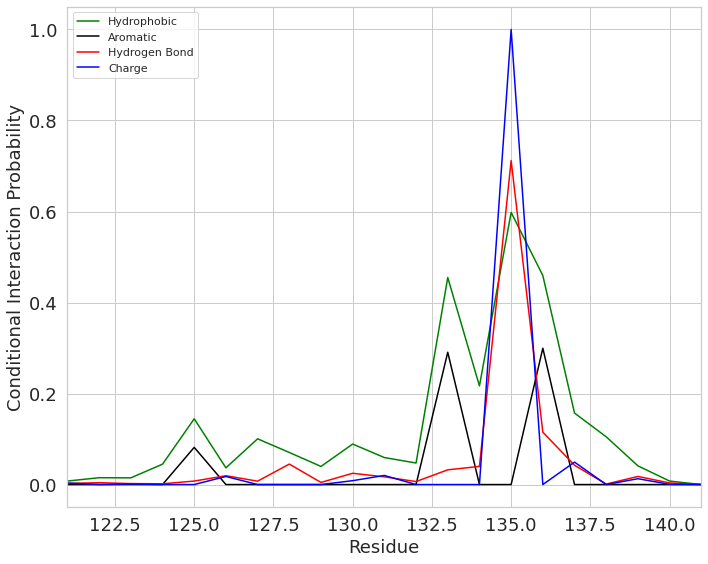

In [27]:
plt.figure(figsize=(10,8))
plt.plot(residue_number,Hphob_Cond,label='Hydrophobic',c='green')
plt.plot(residue_number,Stack_Cond,label='Aromatic',c='black')
plt.plot(residue_number,HB_Cond,label='Hydrogen Bond',c='red')
plt.plot(residue_number,Charge_Cond,label='Charge',c='blue')

plt.xlabel('Residue', size=18)
plt.ylabel('Conditional Interaction Probability', size=18)
plt.tick_params(labelsize=18)
plt.xlim(residue_offset, residue_offset+residues-1)
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig(out_dir+'LigandInteractions.D135ChargeContacts.png')
plt.show()

/tmp/ipykernel_18819/1524254789.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  H125=ax[0,0].hist2d(Stackparams['Lig_ring.0'][125][:,1][contact],Stackparams['Lig_ring.0'][125][:,2][contact], bins=26,range=[[0,180],[0,180]], norm=colors.LogNorm(),cmap='jet')
/tmp/ipykernel_18819/1524254789.py:7: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  H133=ax[0,1].hist2d(Stackparams['Lig_ring.0'][133][:,1][contact],Stackparams['Lig_ring.0'][133][:,2][contact], bins=26,range=[[0,180],[0,180]], norm=colors.LogNorm(),cmap='jet')
/tmp/ipykernel_18819/1524254789.py:8: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call

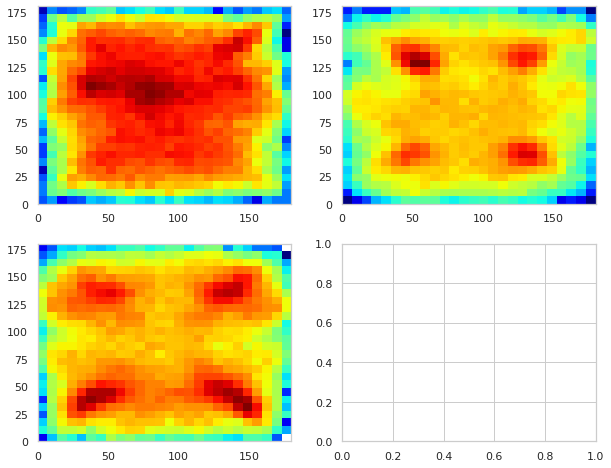

In [28]:

fig, ax = plt.subplots(2,2,figsize=((10,8)))

contact=D135contacts
contact2=np.where(Stackparams['Lig_ring.0'][133][:,0]<= 0.5)

H125=ax[0,0].hist2d(Stackparams['Lig_ring.0'][125][:,1][contact],Stackparams['Lig_ring.0'][125][:,2][contact], bins=26,range=[[0,180],[0,180]], norm=colors.LogNorm(),cmap='jet')
H133=ax[0,1].hist2d(Stackparams['Lig_ring.0'][133][:,1][contact],Stackparams['Lig_ring.0'][133][:,2][contact], bins=26,range=[[0,180],[0,180]], norm=colors.LogNorm(),cmap='jet')
H136=ax[1,0].hist2d(Stackparams['Lig_ring.0'][136][:,1][contact],Stackparams['Lig_ring.0'][136][:,2][contact], bins=26,range=[[0,180],[0,180]], norm=colors.LogNorm(),cmap='jet')

plt.savefig(out_dir+'StackingHistograms.D135.png')
#plt.clf()
plt.show()


/tmp/ipykernel_18819/701748808.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  H125=ax[0,0].hist2d(Stackparams['Lig_ring.0'][125][:,1][contact3],Stackparams['Lig_ring.0'][125][:,2][contact3], bins=36,range=[[0,180],[0,180]],norm=colors.LogNorm(),cmap='jet')
/tmp/ipykernel_18819/701748808.py:12: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  H133=ax[0,1].hist2d(Stackparams['Lig_ring.0'][133][:,1][contact3],Stackparams['Lig_ring.0'][133][:,2][contact3], bins=36,range=[[0,180],[0,180]], norm=colors.LogNorm(),cmap='jet')
/tmp/ipykernel_18819/701748808.py:19: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please ca

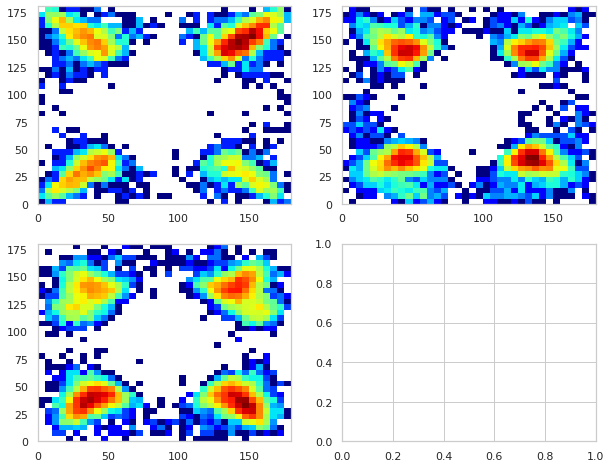

In [29]:
contact=D135contacts
contact2=np.where(Stackparams['Lig_ring.0'][125][:,0]<= 0.5)
contact3=np.intersect1d(contact,contact2)
fig, ax = plt.subplots(2,2,figsize=((10,8)))

H125=ax[0,0].hist2d(Stackparams['Lig_ring.0'][125][:,1][contact3],Stackparams['Lig_ring.0'][125][:,2][contact3], bins=36,range=[[0,180],[0,180]],norm=colors.LogNorm(),cmap='jet')
# np.savetxt(outdir+'Lig_ring.0.Y125.D135contact.stackparams.all.dat',Stackparams['Lig_ring.0'][125][contact3][:,1:3],fmt='%.4f')
# np.savetxt(outdir+'Lig_ring.0.Y125.D135contact.stackparams.dist_lt_0.5.dat',Stackparams['Lig_ring.0'][125][contact3][:,1:3],fmt='%.4f')

contact2=np.where(Stackparams['Lig_ring.0'][133][:,0]<= 0.5)
contact3=np.intersect1d(contact,contact2)
H133=ax[0,1].hist2d(Stackparams['Lig_ring.0'][133][:,1][contact3],Stackparams['Lig_ring.0'][133][:,2][contact3], bins=36,range=[[0,180],[0,180]], norm=colors.LogNorm(),cmap='jet')

# np.savetxt(outdir+'Lig_ring.0.Y133.D135contact.stackparams.all.dat',Stackparams['Lig_ring.0'][133][contact3][:,1:3],fmt='%.4f')
# np.savetxt(outdir+'Lig_ring.0.Y133.D135contact.stackparams.dist_lt_0.5.dat',Stackparams['Lig_ring.0'][133][contact3][:,1:3],fmt='%.4f')

contact2=np.where(Stackparams['Lig_ring.0'][136][:,0]<= 0.5)
contact3=np.intersect1d(contact,contact2)
H136=ax[1,0].hist2d(Stackparams['Lig_ring.0'][136][:,1][contact3],Stackparams['Lig_ring.0'][136][:,2][contact3], bins=36,range=[[0,180],[0,180]], norm=colors.LogNorm(),cmap='jet')


# np.savetxt(outdir+'Lig_ring.0.Y136.D135contact.stackparams.all.dat',Stackparams['Lig_ring.0'][136][contact3][:,1:3],fmt='%.4f')
# np.savetxt(outdir+'Lig_ring.0.Y136.D135contact.stackparams.dist_lt_0.5.dat',Stackparams['Lig_ring.0'][136][contact3][:,1:3],fmt='%.4f')

plt.savefig(out_dir+'StackingHistograms.D135.dist_lt_0.5.png')
plt.show()

In [8]:
sequence = (' %s' % [residue for residue in trj.topology.residues])
sequence_prot = ()
print("Whole sequence :",sequence); print("\n")
print("Protein sqeuence :",)
resindex = (' %s' % [residue.index for residue in trj.topology.residues])
print(resindex)

Whole sequence :  [ASP121, ASN122, GLU123, ALA124, TYR125, GLU126, MET127, PRO128, SER129, GLU130, GLU131, GLY132, TYR133, GLN134, ASP135, TYR136, GLU137, PRO138, GLU139, ALA140, ASP121, <1>1, NA1, NA2, NA3, NA4, NA5, NA6, NA7]


Protein sqeuence :
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]


In [10]:
contact_maps = []
for i in range(0, 20):
    # print(i)
    contact_map = []
    for j in range(0, 20):
        dist1 = md.compute_contacts(trj, [[i, 21]], scheme='closest-heavy')
        dist2 = md.compute_contacts(trj, [[j, 21]], scheme='closest-heavy')
        array1 = np.asarray(dist1[0]).astype(float)
        array2 = np.asarray(dist2[0]).astype(float)
        contact1 = np.where(array1 < 0.6, 1, 0)
        contact2 = np.where(array2 < 0.6, 1, 0)
        sum = contact1 + contact2
        contact = np.where(sum == 2, 1, 0)
        contacts = np.average(contact)
        contact_map.append(contacts)
    contact_maps.append(contact_map)
final_map_L = np.asarray(contact_maps).astype(float)

In [11]:
contact_maps = []
contact_distances = []
for i in range(0, 20):
    contact_map = []
    contact_distance = []
    for j in range(0, 20):
        if i == j:
            contacts = 0
        else:
            dist = md.compute_contacts(trj, [[i, j]])
            array = np.asarray(dist[0]).astype(float)
            distance = np.average(array)
            contact_distance.append(distance)
            contact = np.where(array < 1.2, 1, 0)
            contacts = np.average(contact)
        contact_map.append(contacts)
    contact_maps.append(contact_map)
    contact_distances.append(contact_distance)
    
final_map = np.asarray(contact_maps).astype(float)
# final_distance = np.asarray(contact_distances).astype(float)

/tmp/ipykernel_29961/1463521179.py:6: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.get_shared_y_axes().join(ax1,ax2)


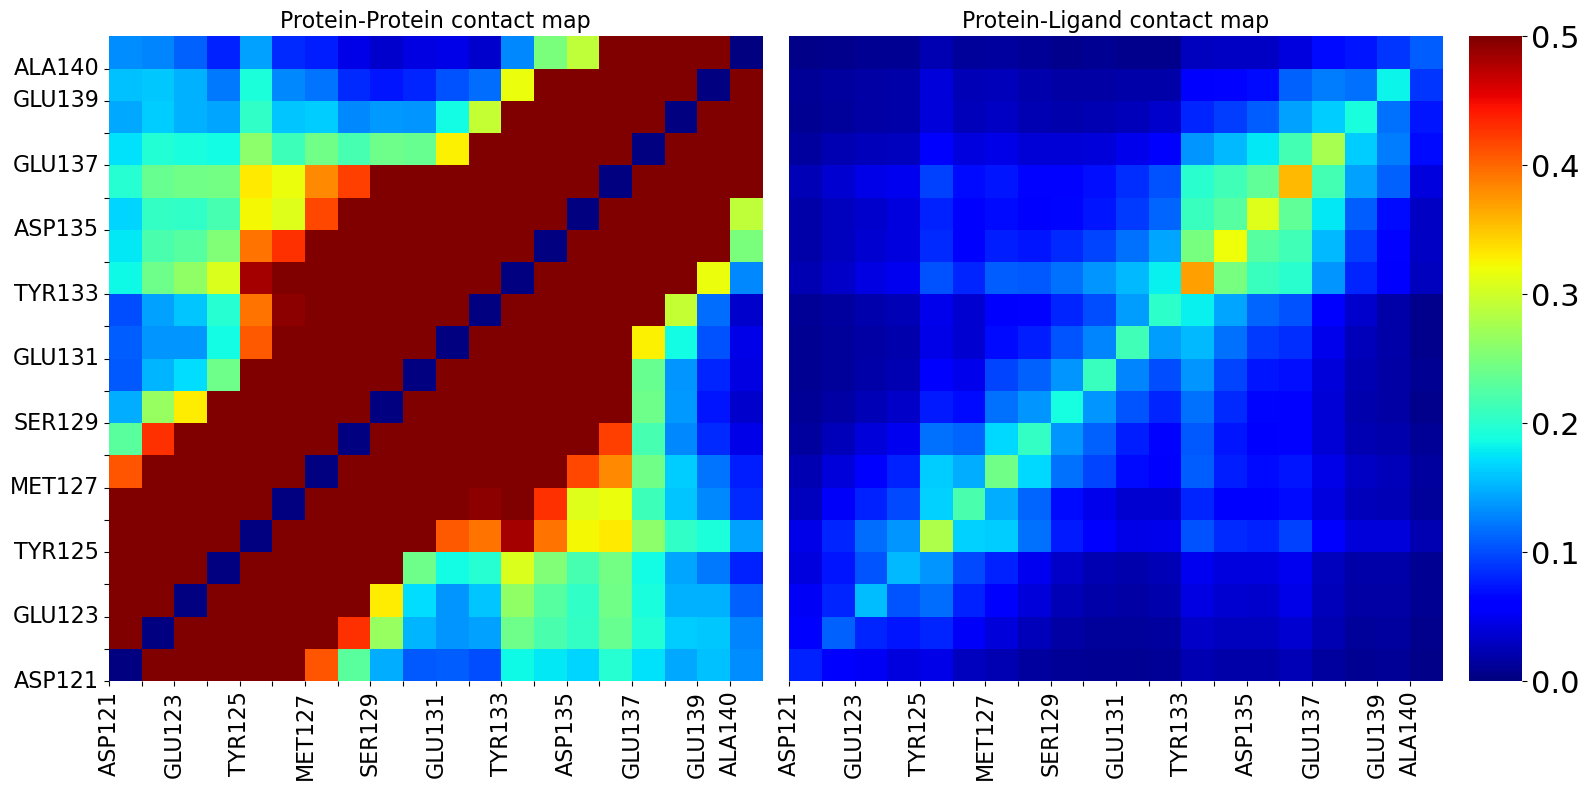

In [12]:
sequence=  ['ASP121', '', 'GLU123', '', 'TYR125', '', 'MET127', '', 'SER129', '', 'GLU131',
            '', 'TYR133', '', 'ASP135', '', 'GLU137', '', 'GLU139', 'ALA140']

f,(ax1,ax2, axcb) = plt.subplots(1,3, gridspec_kw={'width_ratios':[1,1,0.08]},figsize=(16,8))

ax1.get_shared_y_axes().join(ax1,ax2)
g1 = sns.heatmap(final_map,cmap="jet",cbar=False,ax=ax1, vmin=0.0, vmax=0.5)
g1.set_xticks(range(20), sequence, rotation=90, size=16)
g1.set_yticks(range(0, 20), sequence,rotation=0, size=16)
g1.set_ylabel('')
g1.set_xlabel('')
g1.invert_yaxis()
#g1.grid(which='both', alpha=0.5)
g1.set_title("Protein-Protein contact map", size=16)

g2 = sns.heatmap(final_map_L,cmap="jet",ax=ax2, cbar_ax=axcb, vmin=0.0, vmax=0.5)
g2.set_xticks(range(20), sequence, rotation=90, size=16)
g2.set_ylabel('')
g2.set_xlabel('')
g2.invert_yaxis()
#g2.grid(which='both',alpha=0.5)
g2.set_yticks([])
g2.set_title("Protein-Ligand contact map", size=16)


# may be needed to rotate the ticklabels correctly:
# for ax in [g1,g2]:
    
#     ax.set_xticklabels(sequence, rotation=90)
#     ax.set_xticks()
#     tly = ax.get_yticklabels()
#     ax.set_yticklabels(tly, rotation=0)


axcb.tick_params(labelsize=22)
plt.tight_layout()


In [15]:
with open(out_dir+'l_contact_map.json', 'w') as file_:
     json.dump(final_map_L, file_, cls=NpEncoder)
with open(out_dir+'p_contact_map.json', 'w') as file_:
     json.dump(final_map, file_, cls=NpEncoder)

In [16]:
final_map

array([[0.        , 1.        , 1.        , 1.        , 0.99988478,
        0.64391132, 0.40978352, 0.22985645, 0.14671223, 0.10663712,
        0.10876694, 0.10036646, 0.18428754, 0.1776109 , 0.16731465,
        0.19827454, 0.173065  , 0.14601549, 0.15698688, 0.13093117],
       [1.        , 0.        , 1.        , 1.        , 1.        ,
        0.99977135, 0.71345922, 0.42799596, 0.26638125, 0.15142737,
        0.13490997, 0.14079985, 0.24152008, 0.21889316, 0.20531574,
        0.23756379, 0.19699448, 0.16315852, 0.1611025 , 0.12873203],
       [1.        , 1.        , 0.        , 1.        , 1.        ,
        1.        , 0.99971014, 0.57103545, 0.33002487, 0.17047878,
        0.13597398, 0.15960731, 0.26229893, 0.22785715, 0.20425173,
        0.24231584, 0.19072022, 0.14903109, 0.14962251, 0.10968513],
       [1.        , 1.        , 1.        , 0.        , 1.        ,
        1.        , 1.        , 0.99953011, 0.50605956, 0.2406244 ,
        0.18714201, 0.19786945, 0.30779583, 0